In [52]:
import scipy.io.wavfile as wav
import numpy as np

In [53]:
output = np.fft.fft([0, 0, 0, 1, 0, 0, 0, 0, 0])

In [54]:
inverse = np.fft.ifft(output)
inverse.real

array([0., 0., 0., 1., 0., 0., 0., 0., 0.])

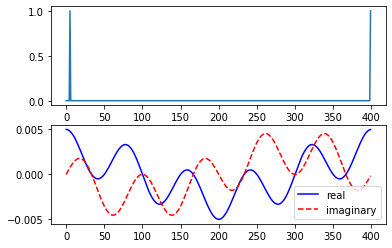

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
t = np.arange(400)
n = np.zeros((400,), dtype=complex)
n[5] = 1.0
n[399] = 1

plt.subplot(2, 1, 1)
plt.plot(t, n)

s = np.fft.ifft(n)
plt.subplot(2, 1, 2)
plt.plot(t, s.real, 'b-', t, s.imag, 'r--')

plt.legend(('real', 'imaginary'))
plt.show()

In [451]:
import numpy as np
import IPython.display as ipd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks
import PIL.Image as Image
import os

# https://github.com/YerevaNN/Spoken-language-identification/blob/master/augment_data.py

def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))
    
    print(type(sig[0]))
    
    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = int(np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1)
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))
    
    frames = stride_tricks.as_strided(samples, shape=(cols, frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win
    
    return np.fft.rfft(frames)


def logscale_spec(spec, sr=44100, factor=20., alpha=1.0, f0=0.9, fmax=1):
    # Crop the bins so that we have 431 rows with 256 columns
    spec = spec[:, 0:256]
    
    # Time bins = number of rows, freqbins = number of columns (256)
    timebins, freqbins = np.shape(spec)
    
    # 256 evenly spaced numbers between 0 and 1
    scale = np.linspace(0, 1, freqbins) #** factor
    
    # http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=650310&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel4%2F89%2F14168%2F00650310
    scale = np.array(list(map(lambda x: x * alpha if x <= f0 else (fmax-alpha*f0)/(fmax-f0)*(x-f0)+alpha*f0, scale)))
    
    # Default output is an array [1., 2., 3., ... 255.]
    scale *= (freqbins-1)/max(scale)

    # 431 rows with 256 columns of 0.+0j
    newspec = np.complex128(np.zeros([timebins, freqbins]))
    
    # Gives a straight line response... 
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    
    freqs = [0.0 for i in range(freqbins)]
    totw = [0.0 for i in range(freqbins)]
    for i in range(0, freqbins):
        if (i < 1 or i + 1 >= freqbins):
            newspec[:, i] += spec[:, i]
            freqs[i] += allfreqs[i]
            totw[i] += 1.0
            continue
        else:
            # scale[15] = 17.2
            w_up = scale[i] - np.floor(scale[i])
            w_down = 1 - w_up
            j = int(np.floor(scale[i]))
           
            newspec[:, j] += w_down * spec[:, i]
            freqs[j] += w_down * allfreqs[i]
            totw[j] += w_down
            
            newspec[:, j + 1] += w_up * spec[:, i]
            freqs[j + 1] += w_up * allfreqs[i]
            totw[j + 1] += w_up
    
    for i in range(len(freqs)):
        if (totw[i] > 1e-6):
            freqs[i] /= totw[i]
    
    return newspec, freqs


def savefftimage(audiopath, binsize=2**10, name='tmp.png', alpha=1, offset=0):
    samplerate, samples = wav.read(audiopath)
    s = stft(samples, binsize)
    sshow, freq = logscale_spec(s, factor=1, sr=samplerate, alpha=alpha)
    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel
    timebins, freqbins = np.shape(ims)
    ims = np.transpose(ims)
    ims = ims[0:256, offset:offset+768] # 0-11khz, ~9s interval
    #print "ims.shape", ims.shape
    
    image = Image.fromarray(ims) 
    image = image.convert('L')
    image.save(name)
    

def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="gray", channel=0, name='tmp.png', alpha=1, offset=0):
    samplerate, samples = wav.read(audiopath)
    
    figure(num=None, figsize=(10, 20), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(6, 1, 1)
    t = np.arange(len(samples))
    plt.plot(t, samples)
    
    s = stft(samples, binsize)
    print(np.shape(s))
    plt.subplot(6, 1, 2)
    t = np.arange(len(s))
    plt.plot(t, s)
    
    index = 10
    
    plt.subplot(6, 1, 3)
    t = np.arange(len(s[index]))
    plt.plot(t, s[index])

    ifft = np.fft.irfft(s[index])
    t = np.arange(len(ifft))
    
    plt.subplot(6, 1, 4)
    plt.plot(t, ifft)
    
    sshow, freq = logscale_spec(s, factor=1, sr=samplerate, alpha=alpha)

    ffft = sshow[index]
    t = np.arange(len(ffft))
    plt.subplot(6, 1, 5)
    plt.plot(t, ffft)
    
    fifft = np.fft.irfft(sshow[index])
    t = np.arange(len(fifft))
    plt.subplot(6, 1, 6)
    plt.plot(t, fifft)
    
    sshow = sshow[2:, :]
    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel
    timebins, freqbins = np.shape(ims)
    
    ims = np.transpose(ims)
    ims = ims[0:256, offset:offset+768] # 0-11khz, ~9s interval
    #print "ims.shape", ims.shape
    
    image = Image.fromarray(ims) 
    image = image.convert('L')
    image.save(name)

    return ifft, fifft

In [452]:
alpha = np.random.uniform(0.9, 1.1)
offset = np.random.randint(90)

offset = 0
alpha = 1

filenameen = "data/codetalk-15-20.wav"
filenamecn = "data/twvlog-90-95.wav"

# ifftdata, fifftdata = plotstft(filenamecn, name='/tmp/testing.png', alpha=alpha, offset=offset)
savefftimage(filenamecn, name='/tmp/testing.png', alpha=alpha, offset=offset)

<class 'numpy.int16'>


In [444]:
ipd.Audio('data/codetalk-15-20.wav')

In [418]:
ipd.Audio(ifftdata, rate=44100)

In [419]:
ipd.Audio(fifftdata, rate=44100)